# Root finding
## Open methods
The fixpt function does a simple fixed‑point iteration to solve (x = g(x)):

Starts from x0, applies g each loop: x1 = g(x0).
Computes the relative change ea = abs((x1 - x0) / x1); stops early when this drops below Ea (default 1e-7) or after maxit iterations (default 30).
Returns (x1, ea, i+1) → the latest estimate, the last relative error, and how many iterations were performed.
In cell 2, g_store wraps the same g used for the friction factor so it can record each f estimate in fvals, then calls fixpt(g_store, f0) to run the iterations, and plots the stored sequence to show convergence.

In [1]:
def fixpt(g,x0,Ea=1.e-7,maxit=30):
    """
    This function solves x=g(x) using fixed-point iteration.
    The method is repeated until either the relative error
    falls below Ea (default 1.e-7) or reaches maxit (default 30).
    Input:
        g = name of the function for g(x)
        x0 = initial guess for x
        Ea = relative error threshold
        maxit = maximum number of iterations
    Output:
        x1 = solution estimate
        ea = relative error
        i+1 = number of iterations
    """    
    for i in range(maxit):
        x1 = g(x0)
        ea = abs((x1-x0)/x1)
        if ea < Ea:  break
        x0 = x1
    return x1,ea,i+1



Example below: g(f) is the Colebrook–White relationship rearranged as a fixed‑point update for the Fanning friction factor in turbulent pipe flow. Given a current guess f, it computes a new friction‑factor estimate that balances viscous effects (via Reynolds number Re) and wall roughness (eps, pipe diameter D). Iterating g solves the implicit Colebrook equation that links friction factor to flow regime and roughness, i.e., the dimensionless resistance to flow (pressure drop) in the pipe.

In [2]:
import numpy as np
rho = 1.23  # kg/m3
mu = 1.79e-5  # Pa*s
D = 0.005  # m
V = 40  # m/s
eps = 1.5e-6  # m
Re = rho*V*D/mu  # Reynolds number

def g(f):
    fr = -4*np.log10(eps/3.7/D+1.26/Re/np.sqrt(f))
    return 1/fr**2

f0 = 0.001
fsoln,ea,n = fixpt(g,f0)
print('Fanning friction factor = ',fsoln)
print('Relative error = ',ea)
print('Number of iterations = ',n)



Fanning friction factor =  0.007248917198656729
Relative error =  4.330091759458145e-08
Number of iterations =  10


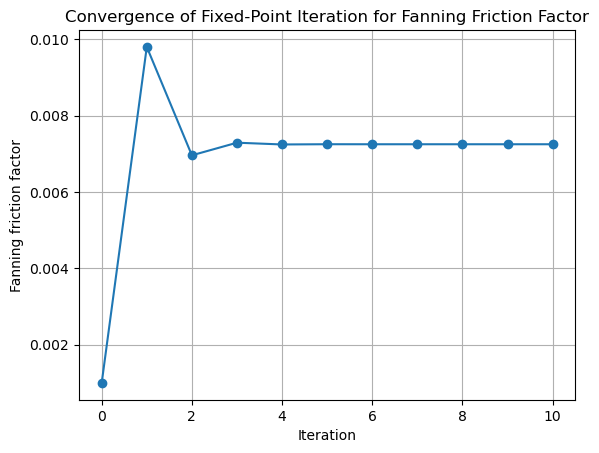

In [3]:
# make plots illustrating convergence
import matplotlib.pyplot as plt 
fvals = []
def g_store(f):
    f_new = g(f)
    fvals.append(f_new)
    return f_new    
fvals.append(f0)
fixpt(g_store,f0)
plt.plot(fvals,'o-')
plt.xlabel('Iteration')
plt.ylabel('Fanning friction factor')
plt.title('Convergence of Fixed-Point Iteration for Fanning Friction Factor')
plt.grid()
plt.show()


## Newton-Raphson
The function newtraph below is a small Newton–Raphson solver for scalar equations f(x)=0:

Inputs: 
f (function), fp (its derivative), initial guess x0, relative error tolerance Ea (default 1e-7), and maxit (default 30).
Loop: computes the Newton step x1 = x0 - f(x0) / fp(x0), then the relative change ea = abs((x1 - x0) / x1). Stops early when ea < Ea or after maxit steps, otherwise sets x0 = x1 and repeats.
Returns (x1, f(x1), ea, i+1): the root estimate, the residual at that point, the last relative error, and iteration count.


In [4]:
def newtraph(f,fp,x0,Ea=1.e-7,maxit=30):
    """
    This function solves f(x)=0 using the Newton-Raphson method.
    The method is repeated until either the relative error
    falls below Ea (default 1.e-7) or reaches maxit (default 30).
    Input:
        f = name of the function for f(x)
        fp = name of the function for f'(x)
        x0 = initial guess for x
        Ea = relative error threshold
        maxit = maximum number of iterations
    Output:
        x1 = solution estimate
        f(x1) = equation error at solution estimate
        ea = relative error
        i+1 = number of iterations
    """    
    for i in range(maxit):
        x1 = x0 - f(x0)/fp(x0)
        ea = abs((x1-x0)/x1)
        if ea < Ea:  break
        x0 = x1
    return x1,f(x1),ea,i+1



Example:
Defines f(x) = x^2 - 9 and derivative fp(x) = 2x.
Starts from x0 = 5.
Calls newtraph(f, fp, x0, Ea=1e-5). Newton steps converge to the positive root of x^2 - 9 = 0, which is x ≈ 3.
Prints the root estimate, the function value at that estimate (near zero), the final relative error (below 1e-5), and the number of iterations taken.

In [5]:
def f(x):
    return x**2-9

def fp(x):
    return 2*x

x0 = 5
(xsoln,fxsoln,ea,n) = newtraph(f,fp,x0,Ea=1.e-5)
print('Solution = {0:8.5g}'.format(xsoln))
print('Function value at solution = {0:8.5e}'.format(fxsoln))
print('Relative error = {0:8.3e}'.format(ea))
print('Number of iterations = {0:5d}'.format(n))


Solution =        3
Function value at solution = 0.00000e+00
Relative error = 4.657e-10
Number of iterations =     5


## Secant method
secant is a root finder for f(x)=0 that avoids needing a derivative:

Inputs: \
f function; \
two initial guesses x0, x1; \
relative error tolerance Ea (default 1e-7); \
iteration cap maxit (default 30). 

Keeps the last two points and their function values (x0,f0 and x1,f1), \
then updates with the secant step \
(x_{2} = x_{1} - f_{1} (x_{1}-x_{0}) / (f_{1}-f_{0})). 

Computes relative change ea = abs((x2 - x1)/x2) and stops early when ea < Ea or a root is hit (f1 == 0). Raises a ZeroDivisionError if f1 == f0 (would divide by zero).

Returns (x2, f(x2), ea, i+1): the latest estimate, its residual, final relative error, and iterations performed.

In [6]:
def secant(f,x0,x1,Ea=1.e-7,maxit=30):
    """
    This function solves f(x)=0 using the secant method.
    The method is repeated until either the relative error
    falls below Ea (default 1.e-7) or reaches maxit (default 30).
    Input:
        f = name of the function for f(x)
        x0 = first initial guess for x
        x1 = second initial guess for x
        Ea = relative error threshold
        maxit = maximum number of iterations
    Output:
        x2 = solution estimate
        f(x2) = equation error at solution estimate
        ea = relative error
        i+1 = number of iterations
    """
    f0 = f(x0)
    f1 = f(x1)
    for i in range(maxit):
        denom = f1 - f0
        if denom == 0:
            raise ZeroDivisionError("Secant method breakdown: f(x1) and f(x0) are equal.")
        x2 = x1 - f1 * (x1 - x0) / denom
        f2 = f(x2)
        ea = abs((x2 - x1) / x2)
        if ea < Ea:
            break
        x0, f0, x1, f1 = x1, f1, x2, f2
    return x2, f2, ea, i+1


In [7]:
# Example usage of secant method
def f(x):
    return x**2-9

x0 = 5
x1 = 6
(xsoln,fxsoln,ea,n) = secant(f,x0,x1,Ea=1.e-5)
print('Solution = {0:8.5g}'.format(xsoln))
print('Function value at solution = {0:8.5e}'.format(fxsoln))
print('Relative error = {0:8.3e}'.format(ea))
print('Number of iterations = {0:5d}'.format(n))

# comparing with newton-raphson
def fp(x):
    return 2*x
(xsoln,fxsoln,ea,n) = newtraph(f,fp,x0,Ea=1.e-5)
print('Solution = {0:8.5g}'.format(xsoln))
print('Function value at solution = {0:8.5e}'.format(fxsoln))
print('Relative error = {0:8.3e}'.format(ea))
print('Number of iterations = {0:5d}'.format(n))


Solution =        3
Function value at solution = 3.44546e-10
Relative error = 2.977e-07
Number of iterations =     6
Solution =        3
Function value at solution = 0.00000e+00
Relative error = 4.657e-10
Number of iterations =     5


## Brent's Method 
brentsimp is an implementation of Brent’s root-finding method: it combines bisection (guaranteed bracketing) with faster open methods (secant and inverse quadratic interpolation) to find a root in [xl, xu] where f changes sign.

How it works:

Starts with endpoints a=xl, b=xu and their function values; keeps a third point c to support interpolation.
Always maintains a bracketing interval with opposite signs (fa, fb); swaps points as needed so |fb| is the smallest magnitude.
Each loop:
Checks convergence via interval half-width m=(a-b)/2 and a floating-point tolerance tol = 2*eps*max(|b|,1); exits when the interval is tiny or fb is zero.
Chooses a step:
If recent steps are reliable (abs(e) >= tol and |fc| > |fb|), tries an open-method step:
Secant when a == c.
Inverse quadratic interpolation otherwise.
Accepts the proposed step only if it’s not too aggressive (2*p < 3*m*q - |tol*q| and p < |0.5*e*q|); else falls back.
Otherwise, falls back to a bisection step (d = m).
Updates the bracket and function values and repeats.
Return value: the latest b, the best current root estimate.

Example in the same cell: brentsimp(lambda x: x**10 - 1, 0.1, 5) finds the positive root of (x^{10}-1=0), which is near x=1, starting from a sign-changing bracket [0.1, 5].

In [8]:
import numpy as np
eps = np.finfo(float).eps
def brentsimp(f,xl,xu):
    a = xl ; b = xu ; fa = f(a) ; fb = f(b)
    c = a ; fc = fa ; d = b - c ; e = d
    while True:
        if fb == 0: break
        if np.sign(fa) == np.sign(fb):  # rearrange points as req'd
            a = c ; fa = fc ; d = b - c ; e = d
        if abs(fa) < abs(fb):
            c = b ; b = a ; a = c
            fc = fb ; fb = fa ; fa = fc
        m = (a-b)/2  # termination test and possible exit
        tol = 2 * eps * max(abs(b),1)
        if abs(m) < tol or fb == 0: break
        # choose open methods or bisection
        if abs(e) >= tol and abs(fc) > abs(fb):
            s = fb/fc
            if a == c: 
                # secant method here
                p = 2*m*s
                q = 1 - s
            else:
                # inverse quadratic interpolation here
                q = fc/fa ; r = fb/fa
                p = s * (2*m*q*(q-r)-(b-c)*(r-1))
                q = (q-1)*(r-1)*(s-1)
            if p > 0: 
                q = -q
            else:
                p = -p
            if 2*p < 3*m*q - abs(tol*q) and p < abs(0.5*e*q):
                e = d ; d = p/q
            else:
                d = m ; e = m
        else:
            # bisection here
            d = m; e = m
        c = b ; fc = fb
        if abs(d) > tol:
            b = b + d
        else:
            b = b - np.sign(b-a)*tol
        fb = f(b)
    return b



In [9]:
xsoln = brentsimp(lambda x: x**10-1,0.1,5)
print('Solution = ',xsoln)

xsoln = brentsimp(lambda x: x**2-9,0.1,5)
print('Solution = ',xsoln)



Solution =  1.0
Solution =  3.0
